# 왜 가중치 규제를 하는가?
- 기울기가 작을수록 일반화가 좋다고 할 수 있기 때문이다.

## 가중치를 규제하는 방법
- L1 규제
- L2 규제

# L1 규제 (라쏘 - Lasso)
- 손실 함수 + L1 노름(norm)
- $α$는 하이퍼 파라미터
  - $\vert\vert{w}\vert\vert_1 = \sum\limits_{i=1}^{n}\vert{w_i}\vert$
  - $L = -(y\log(a) + (1-y)\log(1-a)) + α\sum\limits_{i=1}^{n}\vert{w_i}\vert$
  <br> -> 손실 함수 + $\alpha * (L1 노름)$
  - $\frac{𝜹}{𝜹w}L = -(y-a)x + α * sign(w)$
    - -> w_grad += alpha * np.sign(w)

# L2 규제 (릿지 - Ridge)
- 손실 함수 + L2 노름(norm)
- w가 규제에 직접적인 영향을 주기에 효과적이다.
  - L2노름(유클리드 거리) = $\vert\vert{w}\vert\vert_2 = \sqrt{\sum\limits_{i=1}^{n}\vert{w_i}\vert^2}$ 
  -  $L = -(y\log(a) + (1-y)\log(1-a)) + \frac{1}{2}α\sum\limits_{i=l}^{n}\vert{w_i}\vert^2$ 
  <br> -> 손실 함수 + $\alpha * \frac{1}{2} * (L2노름)^2$
  - $\frac{𝜹}{𝜹w}L = -(y-a)x + α * w$
    - -> w_grad += alpha * w

# L1, L2 규제를 로지스틱 회귀에 적용합니다.

In [34]:
import numpy as np
class SingleLayer:
    def __init__(self, learning_rate=0.1, l1=0, l2=0):                          # 규제 적용을 위한 매개변수 추가
        self.w = None
        self.b = None
        self.losses = []                    # 손실을 저장하는 리스트
        self.val_losses = []                # 검증 세트의 손실 저장
        self.w_history = []                 # 가중치를 기록하기 위한 변수
        self.lr = learning_rate             # 학습률
        self.l1 = l1                                                            # 규제 하이퍼 파라미터 적용
        self.l2 = l2                                                            # 규제 하이퍼 파라미터 적용
    
    def forpass(self, x):
        z = np.sum(x * self.w) + self.b     # 직선의 방정식을 계산
        # z = w1*x1 + w2*x2 ''' wn*xn + b
        return z
    
    def backprop(self, x, err):
        # 가중치와 절편에 대한 그레이디언트를 계산, 반환
        w_grad = x * err
        b_grad = 1 * err
        return w_grad, b_grad
    
    # 확률적 경사하강법을 적용한 훈련법
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        self.w = np.ones(x.shape[1])        # 가중치를 초기화 합니다.
        self.b = 0                          # 절편을 초기화 합니다.
        self.w_history.append(self.w.copy())# 가중치를 기록합니다.
        np.random.seed(42)                  # 랜덤시드 지정
        for i in range(epochs):             # epochs만큼 반복합니다.
            loss = 0                        # 손실을 0으로 초기화합니다.
            indexes = np.random.permutation(np.arange(len(x))) # 확률적 경사하강법을 적용하기 위한 인덱스 섞기
            for i in indexes:
                z = self.forpass(x[i])       # 정방향 계산
                a = self.activation(z)      # 활성화 함수 적용
                err = -(y[i] - a)            # 오차 계산
                w_grad, b_grad = self.backprop(x[i], err) # 역방향 계산
                w_grad += self.l1 * np.sign(self.w) + self.l2 * self.w          # 그레이디언트에서 페널티 항의 미분값을 더합니다.
                self.w -= self.lr * w_grad  # 가중치 업데이트, 학습률 반영
                self.b -= b_grad            # 절편 업데이트

                self.w_history.append(self.w.copy()) # 가중치를 기록합니다.
                # 안전한 로그 계산을 위해 클리핑한 후 손실을 누적합니다.
                a = np.clip(a, 1e-10, 1-1e-10)
                loss += -(y[i]*np.log(a)+(1-y[i])*np.log(1-a))
            # 에포크 마다 평균 손실을 저장합니다.                               # self.reg_loss()함수 호출
            self.losses.append(loss/len(y) + self.reg_loss())

            # 검증 세트에 대한 손실을 계산합니다.
            self.update_val_loss(x_val, y_val)
    
    def activation(self, z):
        z = np.clip(z, -100, None)          # 안전한 np.exp() 계산을 위한 clip함수
        a = 1 / (1 + np.exp(-z))            # 시그모이드 계산
        return a
    
    def predict(self, x):
        z = [self.forpass(x_i) for x_i in x]    # 선형 함수 적용
        return np.array(z) > 0                  # 계단 함수 적용
    
    def score(self, x, y):                      # 성능을 보여주는 메서드
        return np.mean(self.predict(x) == y)
    def update_val_loss(self, x_val, y_val):                                    # 검증 세트 손실을 업데이트
        '''
        만들어진 모델에 대해 검증 세트(전부)로 손실을 계산한 후 평균을 낸다
        '''
        if x_val is None:
            return
        val_loss = 0
        for i in range(len(x_val)):                                    # 모든 검증세트에 대해 반복
            z = self.forpass(x_val[i])                                 # 정방향 계산
            a = self.activation(z)                                     # 활성화 함수 적용
            a = np.clip(a, 1e-10, 1-1e-10)                             # 안전한 log계산을 위한 clip 함수 적용
            val_loss += -(y_val[i]*np.log(a)+(1-y_val[i])*np.log(1-a)) # val_loss에 더해준다.
        self.val_losses.append(val_loss/len(y_val) + self.reg_loss())                # self.reg_loss()함수 호출
    
    # 로지스틱 손실 함수 계산에 페널티 항 추가하기
    def reg_loss(self):
        return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)

In [35]:
# 데이터 준비
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
cancer = load_breast_cancer()
x = cancer.data
y = cancer.target

# 데이터 나누기 (훈련 세트, 테스트 세트)
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)

# 데이터 나누기 (훈련 세트, 검증 세트)
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

# 데이터 전처리
train_mean = np.mean(x_train, axis=0)   # train_mean = u
train_std = np.std(x_train, axis=0)     # train_std = s

## 훈련 데이터 전처리
x_train_scaled = (x_train - train_mean) / train_std   # x_train_scaled = z
## 검증 데이터 전처리
x_val_scaled = (x_val - train_mean) / train_std
## 테스트 데이터 전처리
x_test_scaled = (x_test - train_mean) / train_std

### L1 규제를 적용한다면

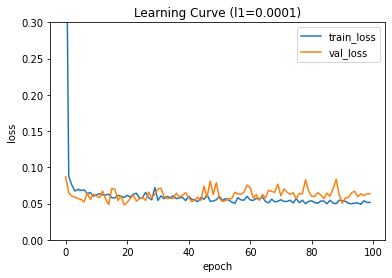

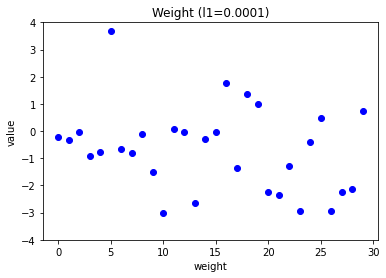

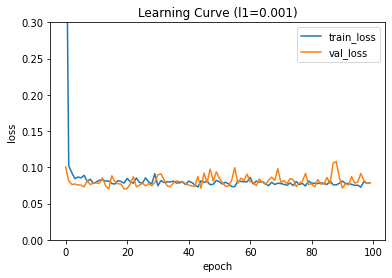

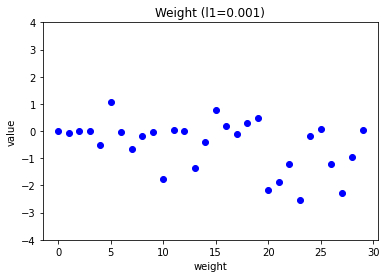

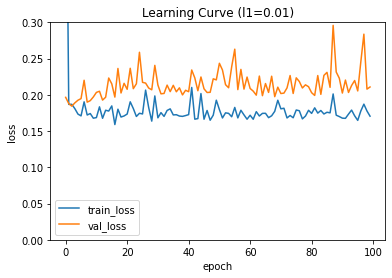

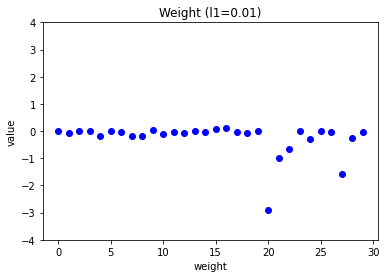

In [36]:
# L1 규제 적용
import matplotlib.pyplot as plt
l1_list = [0.0001, 0.001, 0.01]

for l1 in l1_list:
    lyr = SingleLayer(l1=l1)
    lyr.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val)

    # 손실 그래프 그리기
    plt.plot(lyr.losses)
    plt.plot(lyr.val_losses)
    plt.title('Learning Curve (l1={})'.format(l1))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'val_loss'])
    plt.ylim(0, 0.3)
    plt.show()

    plt.plot(lyr.w, 'bo')
    plt.title('Weight (l1={})'.format(l1))
    plt.ylabel('value')
    plt.xlabel('weight')
    plt.ylim(-4, 4)
    plt.show()

### L2 규제를 적용한다면

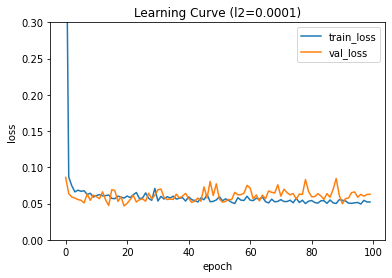

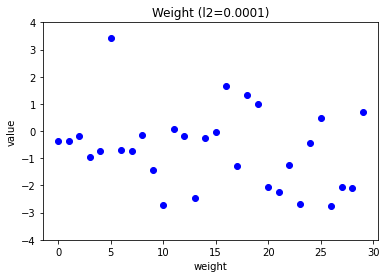

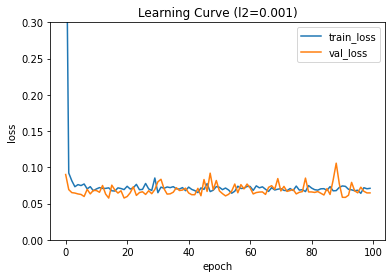

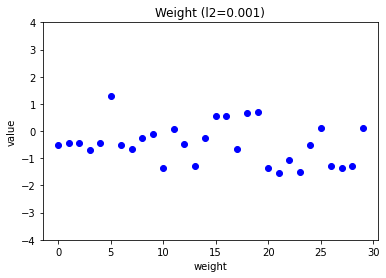

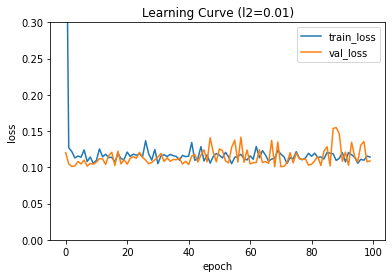

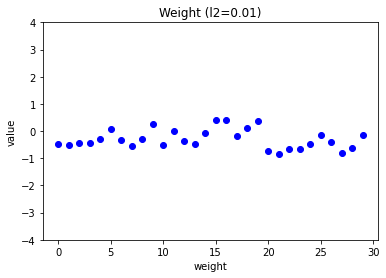

In [37]:
# L2 규제 적용
import matplotlib.pyplot as plt
l2_list = [0.0001, 0.001, 0.01]

for l2 in l1_list:
    lyr = SingleLayer(l2=l2)
    lyr.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val)

    # 손실 그래프 그리기
    plt.plot(lyr.losses)
    plt.plot(lyr.val_losses)
    plt.title('Learning Curve (l2={})'.format(l2))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'val_loss'])
    plt.ylim(0, 0.3)
    plt.show()

    plt.plot(lyr.w, 'bo')
    plt.title('Weight (l2={})'.format(l2))
    plt.ylabel('value')
    plt.xlabel('weight')
    plt.ylim(-4, 4)
    plt.show()

## L1 규제를 했을 때의 성능 VS L2 규제를 했을 때의 성능

In [38]:
# L1 규제
layer5 = SingleLayer(l1=0.001)
layer5.fit(x_train_scaled, y_train, epochs=20)
print('l1 = 0.001 -> ', layer5.score(x_val_scaled, y_val))

# L2 규제
layer6 = SingleLayer(l2=0.001)
layer6.fit(x_train_scaled, y_train, epochs=20)
print('l2 = 0.001 -> ', layer6.score(x_val_scaled, y_val))

l1 = 0.001 ->  0.978021978021978
l2 = 0.001 ->  0.978021978021978


# 05-04 교차검증
- 훈련 세트에서 검증 세트를 떼어내면 훈련할 데이터가 감소한다.
- 이를 방지하는 방법이 '교차검증'이다.

## 교차 검증 과정
  - 훈련 세트를 k개의 폴드(fold)로 나눕니다.
  - 첫 번째 폴드를 검증 세트로 사용하고 나머지(k-1개)를 훈련 세트로 사용합니다.
  - 모델을 훈련한 다음에 검증세트로 평가합니다.
  - 차례대로 다음 폴드를 검증 세트로 사용하여 반복합니다.
  - k개의 검증 세트로 k번 성능을 평가한 후 계산된 성능의 평균을 내어 최종 성능을 계산합니다.

In [39]:
# 잘못된 교차 검증
from sklearn.model_selection import cross_validate  # 교차 검증을 위한 함수
from sklearn.linear_model import SGDClassifier      # 모델

sgd = SGDClassifier(loss='log', penalty='l2', alpha=0.001, random_state=42) # 모델 생성
scores = cross_validate(sgd, x_train_all, y_train_all, cv=10)               # 교차 검증 수행, cv 는 k(폴드 수)를 의미
print(np.mean(scores['test_score']))

0.850096618357488


## 왜 성능이 낮은가?
- 데이터 전처리를 하지 않았기 때문이다.
- 그런데 교차검증을 할 경우 검증 폴드가 표준화 전처리 단계에서 누설되므로 다른 방법을 사용해야한다.

In [40]:
# k-폴드 교차 검증은 검증 세트가 훈련세트에 포함되므로
# 검증 세트를 따로 만들 필요가 없다
# 데이터 준비
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
cancer = load_breast_cancer()
x = cancer.data
y = cancer.target

# 데이터 나누기 (훈련 세트, 테스트 세트)
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)

validation_scores = []

k=10
bins = len(x_train_all) // k

for i in range(k):
    start = i*bins
    end = (i+1)*bins
    val_fold = x_train_all[start:end]
    val_target = y_train_all[start:end]

    train_index = list(range(0, start)) + list(range(end, len(x_train_all)))
    train_fold = x_train_all[train_index]
    train_target = y_train_all[train_index]

    train_mean = np.mean(train_fold, axis=0)
    train_std = np.std(train_fold, axis=0)
    train_fold_scaled = (train_fold - train_mean) / train_std
    val_fold_scaled = (val_fold - train_mean) / train_std

    lyr = SingleLayer(l2=0.01)
    lyr.fit(train_fold_scaled, train_target, epochs=50)
    score = lyr.score(val_fold_scaled, val_target)
    validation_scores.append(score)
print(np.mean(validation_scores))

0.9711111111111113


# Pipeline 클래스를 사용하여 전처리를 수행합니다.
- 검증 세트를 따로 나누지 않고 훈련 세트 전체를 사용합니다.
- 전처리와 모델을 하나의 파이프라인으로 정의합니다.

In [41]:
from sklearn.model_selection import cross_validate  # 교차 검증을 위한 함수
from sklearn.linear_model import SGDClassifier      # 모델
from sklearn.pipeline import make_pipeline          # 파이프라인을 만들어주는 클래스
from sklearn.preprocessing import StandardScaler    # 전처리해주는 클래스

sgd = SGDClassifier(loss='log', penalty='l2', alpha=0.001, random_state=42) # 모델 생성

pipe = make_pipeline(StandardScaler(), sgd)

scores = cross_validate(pipe, x_train_all, y_train_all, cv=10, return_train_score=True)    # 교차 검증 수행, cv 는 k(폴드 수)를 의미
# return_train_score=True : 훈련 폴드의 점수도 반환한다.

print(np.mean(scores['test_score']))
print(np.mean(scores['train_score']))


0.9694202898550724
0.9875478561631581
